# Assignment 4a - Variational Auto-Encoders
## Deep Learning Course - Vrije Universiteit Amsterdam, 2022

#### Instructions on how to use this notebook:

This notebook is hosted on Google Colab. To be able to work on it, you have to create your own copy. Go to *File* and select *Save a copy in Drive*.

You can also avoid using Colab entirely, and download the notebook to run it on your own machine. If you choose this, go to *File* and select *Download .ipynb*.

The advantage of using Colab is that you can use a GPU. You can complete this assignment with a CPU, but it will take a bit longer. Furthermore, we encourage you to train using the GPU not only for faster training, but also to get experience with this setting. This includes moving models and tensors to the GPU and back. This experience is very valuable because for various models and large datasets (like large CNNs for ImageNet, or Transformer models trained on Wikipedia), training on GPU is the only feasible way.

The default Colab runtime does not have a GPU. To change this, go to *Runtime - Change runtime type*, and select *GPU* as the hardware accelerator. The GPU that you get changes according to what resources are available at the time, and its memory can go from a 5GB, to around 18GB if you are lucky. If you are curious, you can run the following in a code cell to check:

```sh
!nvidia-smi
```

Note that despite the name, Google Colab does  not support collaborative work without issues. When two or more people edit the notebook concurrently, only one version will be saved. You can choose to do group programming with one person sharing the screen with the others, or make multiple copies of the notebook to work concurrently.

**Submission:** Upload your notebook in .ipynb format to Canvas. The code and answers to the questions in the notebook are sufficient, no separate report is expected. 

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


## Introduction

In this assignment, we are going to implement a Variational Auto-Encoder (VAE). A VAE is a likelihood-based deep generative model that consists of a stochastic encoder (a variational posterior over latent variables), a stochastic decoder, and a marginal distribution over latent variables (a.k.a. a prior). The model was originally proposed in two concurrent papers:
- [Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.](https://arxiv.org/abs/1312.6114)
- [Rezende, Danilo Jimenez, Shakir Mohamed, and Daan Wierstra. "Stochastic backpropagation and approximate inference in deep generative models." International conference on machine learning. PMLR, 2014.](https://proceedings.mlr.press/v32/rezende14.html)

You can read more about VAEs in Chapter 4 of the following book:
- [Tomczak, J.M., "Deep Generative Modeling", Springer, 2022](https://link.springer.com/book/10.1007/978-3-030-93158-2)

In particular, the goals of this assignment are the following:

- Understand how VAEs are formulated
- Implement components of VAEs using PyTorch
- Train and evaluate a model for image data

### Theory behind VAEs

VAEs are latent variable models trained with variational inference. In general, the latent variable models define the following generative process:
\begin{align}
1.\ & \mathbf{z} \sim p_{\lambda}(\mathbf{z}) \\
2.\ & \mathbf{x} \sim p_{\theta}(\mathbf{x}|\mathbf{z})
\end{align}

In plain words, we assume that for observable data $\mathbf{x}$, there are some latent (hidden) factors $\mathbf{z}$. Then, the training objective is log-likelihood function of the following form:
$$
\log p_{\vartheta}(\mathbf{x})=\log \int p_\theta(\mathbf{x} \mid \mathbf{z}) p_\lambda(\mathbf{z}) \mathrm{d} \mathbf{z} .
$$

The problem here is the intractability of the integral if the dependencies between random variables $\mathbf{x}$ and $\mathbf{z}$ are non-linear and/or the distributions are non-Gaussian.

By introducing variational posteriors $q_{\phi}(\mathbf{z}|\mathbf{x})$, we get the following lower bound (the Evidence Lower Bound, ELBO):
$$
\log p_{\vartheta}(\mathbf{x}) \geq \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z} \mid \mathbf{x})}\left[\log p_\theta(\mathbf{x} \mid \mathbf{z})\right]-\mathrm{KL}\left(q_\phi(\mathbf{z} \mid \mathbf{x}) \| p_\lambda(\mathbf{z})\right) .
$$

Note that we want to *maximize* this objective, therefore, in the code you are going to have to implement NELBO (negative ELBO) as a loss function (i.e., a minimization task). 

## IMPORTS

In [2]:
# DO NOT REMOVE!
import os

import numpy as np
import matplotlib.pyplot as plt

import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.datasets import MNIST

In [3]:
# Check if GPU is available and determine the device
if torch.backends.mps.is_available():
  device = 'mps'  
elif torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

print(f'The available device is {device}')

The available device is mps


In [4]:
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
images_dir = './results/'
os.makedirs(images_dir,exist_ok=True)

## Auxiliary functions

Let us define some useful log-distributions:

In [5]:
# DO NOT REMOVE
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5


def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_bernoulli(x, p, reduction=None, dim=None):
    pp = torch.clamp(p, EPS, 1. - EPS)
    log_p = x * torch.log(pp) + (1. - x) * torch.log(1. - pp)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

## Implementing VAEs

The goal of this assignment is to implement four classes:
- `Encoder`: this class implements the encoder (variational posterior), $q_{\phi}(\mathbf{z}|\mathbf{x})$.
- `Decoder`: this class implements the decoded (the conditional likelihood), $p_{\theta}(\mathbf{x}|\mathbf{z})$.
- `Prior`: this class implements the marginal over latents (the prior), $p_{\lambda}(\mathbf{z})$.
- `VAE`: this class combines all components.

#### Question 0: (3 pt) 
**Fully-connected Neural Networks (MLPs) or Convolutional Neural Networks**

This is not a real question but rather a comment. You are asked to implement your VAE using fully connected neural networks (MLPs) or convolutional neural networks (ConvNets). 

There is a difference in grading of this assignment based on your decision:
- **If you decide to implement your VAE with MLPs and the model works properly, you get 1 pt.**
- **If you decide to implement your VAE with ConvNets and the model works properly, you get 3 pts.**

### Encoder
We start with `Encoder`. Please remember that we assume the Gaussian variational posterior with a diagonal covariance matrix.

Feel free to add other methods to the class as well as arguments to the class initialization.

In [6]:

# YOUR CODE GOES HERE
# NOTE: The class must containt the following functions: 
# (i) reparameterization
# (ii) sample
# Moreover, forward must return the log-probability of variational posterior for given x, i.e., log q(z|x)

class Encoder(nn.Module):
    def __init__(self,encoder_net:torch.nn.Module):
        super(Encoder, self).__init__()

        self.encoder = encoder_net # The Encoder Network . Will be passed as an argument .

    @staticmethod
    def reparameterization(mu, log_var):

        sigma =  torch.exp(0.5 * log_var) # takes the log_var and transforms it to standard deviation .
        # e = torch.normal(mean=0.0, std=1.0, size=sigma.shape)
        e = torch.randn_like(sigma) # error sampled from a standard Gaussian distr. as suggested in the book.

        z =mu + sigma * e 
        return z
    
    
    def encode(self, x):
        
        
        h_e = self.encoder(x) # pass through the network
        mu_e ,log_var_e = torch.chunk(h_e,2,dim=1) #take the output and split it to mu and log_var .

        return mu_e,log_var_e


    def sample(self, x=None, mu_e=None, log_var_e=None):
        """
        Sample from the encoder. 
        If x is given (not equal to None), then copmute variational posterior distribution q(z|x) and sample from it.
        Otherwise, use `mu_e` and `log_var_e` as parameter of the variational posterior and sample from it.

        x: torch.tensor, with dimensionality (mini-batch, x_dim)
             a mini-batch of data points
        mu_e: torch.tensor, with dimensionality (mini-batch, x_dim)
             mean vector of the variational posterior
        log_var_e: torch.tensor, with dimensionality (mini-batch, x_dim)
             log variance of the variational posterior
        return: z: torch.tensor, with dimensionality (mini-batch, z_dim)
        """
        if x is not None:
            mu,log_var = self.encode(x)
            return self.reparameterization(mu=mu,log_var=log_var)

        else:
        
            return self.reparameterization(mu = mu_e,log_var=log_var_e)
        


    def forward(self, x,type = 'log_prob'):
        """
        Compute log-probability of variational posterior for given x, i.e., log q(z|x)
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
             a mini-batch of data points
        """
        if type == 'log_prob':
            mu,log_var = self.encode(x)
            z = self.sample(mu_e=mu,log_var_e=log_var)

            return log_normal_diag(z,mu,log_var)
        else :
            return self.sample(x)

Please answer the following questions:


#### Question 1 (0.5 pt)

Please explain the reparameterization trick and provide a mathematical formula.

ANSWER :

In VAEs , we need to sample z from the distribution $q_{\phi}(\mathbf{z}|\mathbf{x})$ defined by $\mathbf{\mu}$ and $\mathbf{\sigma}$ during the forward pass. However standard backpropagation cannot flow through random sampling because it is not differentiable . As a solution , we introduce  a variable $\mathbf{\epsilon}$ ,that holds  all the randomness : $\mathbf{\epsilon} \sim \mathcal{N}(0, \mathbf{1})$ .This makes $\mathbf{z}$ a differentiable ,deterministic function of the Encoder 
outputs(($\mathbf{\mu}, \mathbf{\sigma}$)) and the noise ($\mathbf{\epsilon}$), allowing gradients to flow back through the network .

$$
\mathbf{z} = \mathbf{\mu} + \mathbf{\sigma} \odot \mathbf{\epsilon}
$$


#### Question 2 (0.25 pt)

Please write down mathematically the log-probability of the encoder (variational posterior).

ANSWER: 

The variational posterior $q_{\phi}(\mathbf{z}|\mathbf{x})$ is modeled as a multivariate Gaussian (since we have a vector of $z_1, z_2, \dots, z_{20}$)with a diagonal covariance matrix. Its log-probability density is the sum of the log-probabilities of the individual dimensions:

$$
\log q_{\phi}(\mathbf{z}|\mathbf{x}) = \sum_{j=1}^{D} \left( -\frac{1}{2}\log(2\pi) - \frac{1}{2}\log(\sigma_j^2) - \frac{(z_j - \mu_j)^2}{2\sigma_j^2} \right)
$$

**Where:**
* $D$ is the dimensionality of the latent space.
* $\mu_j$ and $\sigma_j^2$ are the mean and variance for the $j$-th feature, calculated by the encoder network from the input $\mathbf{x}$.
* $z_j$ is the $j$-th feature of the latent vector $\mathbf{z}$.

### Decoder

The decoder is the conditional likelihood, i.e., $p(\mathbf{x}|\mathbf{z})$. Please remember that we must decide on the form of the distribution (e.g., Bernoulli, Gaussian, Categorical). Please discuss it with a TA or a lecturer if you are in doubt.

In [7]:
# YOUR CODE GOES HERE
# NOTE: The class must containt the following function: 
# (i) sample
# Moreover, forward must return the log-probability of the conditional likelihood function for given z, i.e., log p(x|z)

class Decoder(nn.Module):
    def __init__(self,decoder_net : torch.nn.Module ):
        super(Decoder, self).__init__()

        self.decoder = decoder_net # The decoder netwrok . Will be passed as an argument.
        

    def decode(self,z):
        
        h_d = self.decoder(z) # pass through the network layers.
        d_prob = torch.sigmoid(h_d) # sigmoid is used to output a probability in (0,1)
        return d_prob

    def sample(self, z):
        """
        For a given latent code compute parameters of the conditional likelihood 
        and sample x ~ p(x|z)

        z: torch.tensor, with dimensionality (mini-batch, z_dim)

        return:
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
        """
        x = self.decode(z) 
        
        x_coin_flip = torch.bernoulli(x) #biased coin flip 
        return x_coin_flip

    def forward(self, z, x=None,type = 'log_prob'):
        """
        Compute the log probability: log p(x|z). 
        z: torch.tensor, with dimensionality (mini-batch, z_dim)
        x: torch.tensor, with dimensionality (mini-batch, x_dim)
        """
        if type == 'log_prob':
            x_prob = self.decode(z)
            x_flat = x.view(x.size(0), -1)
            x_prob_flat = x_prob.view(x_prob.size(0), -1)
            return log_bernoulli(x_flat,x_prob_flat,reduction='sum',dim=1) #dim =1. is used to sum the log-probs for every pixel of every record in the batch 
        else:
            return self.sample(z)

Please answer the following questions:

#### Question 3 (0.5 pt)

Please explain your choice of the distribution for image data used in this assignment. Additionally, please write it down mathematically (if you think that presenting it as the log-probability, then please do it).


ANSWER: 


We have selected the **Bernoulli distribution** for the image data.

The input images (MNIST) have pixel values scaled between 0 and 1. In this assignment, we treat each pixel value $x_i$ as the probability of that pixel being 1 or 0. which essentially means active or inactive . The Bernoulli distribution is very effective for modeling such binary or near-binary data. The decoder outputs a probability vector $\mathbf{y}$ (via a sigmoid function), and we maximize the likelihood of the true pixel values under these predicted probabilities.

The log-probability of the image $\mathbf{x}$ given the latent code $\mathbf{z}$ is the sum of the Bernoulli log-probabilities for all $D$ pixels :

$$
\log p_{\theta}(\mathbf{x}|\mathbf{z}) = \sum_{i=1}^{D} \left[ x_i \cdot \log(y_i) + (1 - x_i) \cdot \log(1 - y_i) \right]
$$

**Where:**
* $D$ is the number of pixels (e.g., $28 \times 28 = 784$).
* $x_i$ is the value of the $i$-th pixel in the real input image.
* $y_i$ is the $i$-th output of the decoder (probability), calculated  as $y_i = \text{sigmoid}(\text{Decoder}(\mathbf{z})_i)$.

#### Question 4 (0.5 pt)

Please explain how one can sample from the distribution chosen by you. Please be specific and formal (i.e., provide mathematical formulae). If applicable, please provide a code snippet.

After passing the latent code $\mathbf{z}$ through the decoder network as explained in Question 3, we obtain a tensor of probabilities. Then, for each pixel $i$, we sample a binary value $\in \{0, 1\}$ using that probability. This is equivalent to rolling a biased coin flip for every pixel (e.g., if $p = 0.8$, there is an 80% chance of getting value 1).

**Mathematical Formula:**
$$
x_i \sim \text{Bernoulli}(p_i), \quad \text{where } p_i = [\text{Decoder}(\mathbf{z})]_i
$$

**Code Snippet:**
```python
def decode(self, z):
    h_d = self.decoder(z)       # Pass through the network layers.
    d_prob = torch.sigmoid(h_d) # Sigmoid is used to output a probability in (0,1)
    return d_prob

def sample(self, z):
    """
    For a given latent code compute parameters of the conditional likelihood 
    and sample x ~ p(x|z)
    """
    x = self.decode(z) 
    
    x_coin_flip = torch.bernoulli(x) # Biased coin flip (Bernoulli sampling)
    return x_coin_flip

### Prior

The prior is the marginal distribution over latent variables, i.e., $p(\mathbf{z})$. It plays a crucial role in the generative process and also in synthesizing images of a better quality.

In this assignment, you are asked to implement a prior that is learnable (e.g., parameterized by neural networks). If you decide to implement the standard Gaussian prior only, then please be aware that you will not get any points.


For the learnable prior you can choose one of the following options:


*   Mixture of Gaussians
*   Normalizing Flow


In [8]:
# YOUR CODE GOES HERE
# NOTES:
# (i) Implementing the standard Gaussian prior does not give you any points!
# (ii) The function "sample" must be implemented.
# (iii) The function "forward" must return the log-probability, i.e., log p(z)

class Prior(nn.Module):
    def __init__(self, nett,nets,num_flows,D=20, device='cpu'):
        super(Prior, self).__init__()
        self.device = device

        self.D = D
        self.t  = torch .nn. ModuleList ([ nett() for _ in range (num_flows )])
        self.s = torch.nn.ModuleList([nets() for _ in range(num_flows)])

        self.num_flows = num_flows

    #twisting and scaling 
    def coupling(self,x,index,forward = True):
        (x_a,x_b) = torch.chunk(x,2,1)

        s = self.s[index](x_a)
        t = self.t[index](x_a)

        if forward:
            y_b = (x_b-t) * torch.exp(-s)
        else:
            y_b = torch.exp(s) *x_b + t
        return torch.cat((x_a,y_b),1) , s
    
    def permute(self,x):
        return x.flip(1)
    
    def f(self, x):
               
        #Track the volume change (Jacobian)
        log_det_J,z= torch.zeros(x.shape[0], device=self.device),x
        
        for i in range(self.num_flows):
            #Transform
            z, s = self.coupling(z, i, forward=True)
            
            #Flip so the other half gets updated next time
            z = self.permute(z)
            
            # forward: multiplied by exp(-s), so log_det is sum(-s)
            log_det_J = log_det_J - s.sum(dim=1)
            
        return z, log_det_J
    
    def f_inv(self, z):
       
        x=z 
        # Loop BACKWARDS (from last layer to first)
        for i in reversed(range(self.num_flows)):
            #Undo Permute (Flip back first)
            x = self.permute(x)
            
            #Inverse Transform
            x, _ = self.coupling(x, i, forward=False)
            
        return x

    def log_prob(self, x):
        # Transform Complex Data (z) -> Simple Noise (z_noise)
        z, log_det_J = self.f(x)
        
        
        #Prob = Prob(Noise) + Volume Change
        log_p = log_standard_normal(z,reduction='sum',dim=1) + log_det_J
        return log_p


    def sample(self, batch_size):
       
        z = torch.randn(batch_size , self.D, device=self.device)
        x = self.f_inv (z)
        return x.view(-1, self.D)
    

    def forward(self, z):
        return self.log_prob(z)

#### Question 5 (2 pts max)

**Option 1 (0 pt):  Standard Gaussian**

**NOTE: *If you decide to use the standard Gaussian prior, please indicate it in your answer. However, you will get 0 pt for this question.***

**Option 2 (0.5 pt): Mixture of Gaussains**

Please do the following:
- (0.25 pt) Please explain your prior and write it down mathematically
- (0.15 pt) Please write down its sampling procedure (if necessary, please add a code snippet).
- (0.1 pt) Please write down its log-probability (a mathematical formula).

**Option 3 (2 pts): Normalizing Flow**

Please do the following:
- (1 pt) Please explain your prior and write it down mathematically
- (0.5 pt) Please write down its sampling procedure (if necessary, please add a code snippet).
- (0.5 pt) Please write down its log-probability (a mathematical formula).

ANSWER:

**1.** 

The prior distribution $p(\mathbf{z})$ is modeled using a **Normalizing Flow**. This approach transforms a simple base distribution (a Standard Gaussian) into a complex, learnable prior distribution through a sequence of invertible transformations(twists,scales ,etc).

In this implementation, we use **Affine Coupling Layers** (similar to RealNVP). These layers are computationally efficient because they allow for the exact computation of the Jacobian determinant required for the change of variables formula.

Mathematically, let $z_{base} \sim \mathcal{N}(0, I)$ be a sample from the base distribution. The complex latent variable $z$ is obtained by applying a sequence of invertible transformations. However, for the density estimation (calculating `log_prob`), we utilize the **forward** transformation $f$ which maps the complex latent variable back to the base noise:

$$f: \mathbf{z} \rightarrow \mathbf{z}_{base}$$

The transformation is defined by splitting the input dimension into two parts, $\mathbf{z}_a$ and $\mathbf{z}_b$. The **Affine Coupling Layer** defined in the `coupling` function (with `forward=True`) performs the following operation:

$$
\begin{aligned}
\mathbf{y}_a &= \mathbf{z}_a \\
\mathbf{y}_b &= (\mathbf{z}_b - t(\mathbf{z}_a)) \odot \exp(-s(\mathbf{z}_a))
\end{aligned}
$$

where:
* $s(\cdot)$ and $t(\cdot)$ are scale and translation neural networks.
* $\odot$ denotes element-wise multiplication.

The log-determinant of the Jacobian for this transformation is easily computed as the sum of the negative log-scaling factors, which is tracked in the code as:

$$\log \left| \det \frac{\partial f}{\partial \mathbf{z}} \right| = \sum_{i} -s(\mathbf{z}_a)_i$$

**2.**

To sample from the learned prior, we utilize the invertible nature of the Normalizing Flow. The process involves sampling a latent vector from the simple base distribution (Standard Normal) and then transforming it into the complex prior distribution using the **inverse** flow transformation(essentially we apply the learned transformations to create a more complex space where our sampled values come from. However, we cannot control  which specific  number will be generated only that it will be a representative of the distribution ).

1. Sample a noise vector from the base distribution:
   $$\mathbf{z}_{base} \sim \mathcal{N}(0, I)$$
2. Apply the inverse transformation $f^{-1}$ (implemented as `f_inv`):
   $$\mathbf{z} = f^{-1}(\mathbf{z}_{base})$$

**Code Implementation:**
```python
 def sample(self, batch_size):
       
        z = torch.randn(batch_size , self.D, device=self.device)
        x = self.f_inv (z)
        return x.view(-1, self.D)
```

**3.**

The log-probability is computed using the **Change of Variables Formula**. Since we map the complex input $\mathbf{z}$ (the latent code produced by the encoder) to the simple base space $\mathbf{z}_{\text{base}}$ (Standard Gaussian noise) using the forward flow transformation $f$, we must account for the change in density (volume) induced by this transformation.

**Mathematical Formulation:**
The log-likelihood of a sample $\mathbf{z}$ under the flow-based prior is equal to the log-likelihood of its mapped value in the base distribution, plus the log-determinant of the Jacobian of the transformation:

$$
\log p(\mathbf{z}) = \log p_{\text{base}}(f(\mathbf{z})) + \log \left| \det \frac{\partial f(\mathbf{z})}{\partial \mathbf{z}} \right|
$$

In this implementation, because we use Affine Coupling Layers, the Jacobian matrix is triangular. This allows for efficient computation, as the determinant is simply the product of the diagonal elements (the scaling factors). In log-space, this becomes a summation:

$$
\log \left| \det J \right| = \sum_{i} -s(\mathbf{z}_a)_i
$$



### Complete VAE

The last class is `VAE` tha combines all components. Please remember that this class must implement the **Negative ELBO** in `forward`, as well as `sample` (*hint*: it is a composition of `sample` functions from the prior and the decoder).

In [9]:
# YOUR CODE GOES HERE
# This class combines Encoder, Decoder and Prior.
# NOTES:
# (i) The function "sample" must be implemented.
# (ii) The function "forward" must return the negative ELBO. Please remember to add an argument "reduction" that is either "mean" or "sum".
class VAE(nn.Module):
    def __init__(self,encoder:Encoder,decoder:Decoder,prior:Prior, device='cpu'):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

    def sample(self, batch_size=64):
        z = self.prior.sample(batch_size=batch_size)
        return self.decoder.sample(z)

    def forward(self, x, reduction='mean'):
        # Please correctly implement this function
        
        mu_e, log_var_e = self.encoder.encode(x)
        z = self.encoder.sample(mu_e=mu_e, log_var_e=log_var_e)

        RE = self.decoder.forward(z,x,type='log_prob') # Reconstruction error 

        log_q = log_normal_diag(z, mu_e, log_var_e, reduction='sum', dim=1)
        log_p = self.prior.forward(z)

        KL = log_q-log_p #KL Divergence 


        # Negative ELBO (NELBO)
        NELBO = KL-RE

        if reduction == 'sum':
            return NELBO.sum()
        else:
            return NELBO.mean()

#### Question 6 (0.5 pt)

Please write down mathematically the **Negative ELBO** and provide a code snippet.

ANSWER:


The **Negative ELBO (NELBO)** is derived directly from the variational lower bound (ELBO) formula. To minimize the loss, we take the negative of the ELBO. The objective consists of the Reconstruction term (maximizing data likelihood) and the Regularization term (matching the posterior to the prior).

**Mathematical Formula:**
The Evidence Lower Bound (ELBO) is defined as:
$$
\text{ELBO} = \mathbb{E}_{\mathbf{z} \sim q_{\phi}(\mathbf{z}|\mathbf{x})} [\log p_{\theta}(\mathbf{x}|\mathbf{z})] - \text{KL}(q_{\phi}(\mathbf{z}|\mathbf{x}) || p_{\lambda}(\mathbf{z}))
$$

The Negative ELBO (NELBO) is the negative of this value:
$$
\text{NELBO} = - \text{ELBO} = \text{KL}(q_{\phi}(\mathbf{z}|\mathbf{x}) || p_{\lambda}(\mathbf{z})) - \mathbb{E}_{\mathbf{z} \sim q_{\phi}(\mathbf{z}|\mathbf{x})} [\log p_{\theta}(\mathbf{x}|\mathbf{z})]
$$


**Code Snippet:**
```python
    def forward(self, x, reduction='mean'):
        # Please correctly implement this function
        
        mu_e, log_var_e = self.encoder.encode(x)
        z = self.encoder.sample(mu_e=mu_e, log_var_e=log_var_e)

        RE = self.decoder.forward(z,x,type='log_prob') # Reconstruction error 

        log_q = log_normal_diag(z, mu_e, log_var_e, reduction='sum', dim=1)
        log_p = self.prior.forward(z)

        KL = log_q-log_p #KL Divergence 


        # Negative ELBO (NELBO)
        NELBO = KL-RE

        if reduction == 'sum':
            return NELBO.sum()
        else:
            return NELBO.mean()
```

### Evaluation and training functions

**Please do not remove or modify them.**

In [10]:
# DO NOT REMOVE

def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, (test_batch, _) in enumerate(test_loader):
        test_batch = test_batch.to(device)
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader, shape=(28,28)):
    # real images-------
    num_x = 4
    num_y = 4
    x, _ = next(iter(test_loader))
    x = x.to('cpu').detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], shape)
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, shape=(28,28), extra_name=''):
    x, _ = next(iter(data_loader))
    x = x.to('cpu').detach().numpy()

    # generations-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.to('cpu').detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], shape)
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [11]:
# DO NOT REMOVE

def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader, shape=(28,28)):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, (batch, _) in enumerate(training_loader):
            batch = batch.to(device)
            loss = model.forward(batch, reduction='mean')

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, shape=shape, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

### Setup

**NOTE: *Please comment your code! Especially if you introduce any new variables (e.g., hyperparameters).***

In the following cells, we define `transforms` for the dataset. Next, we initialize the data, a directory for results and some fixed hyperparameters.

In [12]:
# PLEASE DEFINE APPROPRIATE TRANFORMS FOR THE DATASET
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

Please do not modify the code in the next cell.

In [ ]:
# DO NOT REMOVE
#-dataset
dataset = MNIST('./files/', train=True, download=True,
                      transform=transforms_train
                )

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000], generator=torch.Generator().manual_seed(14))

test_dataset = MNIST('./files/', train=False, download=True,
                      transform=transforms_test
                     )
#-dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#-creating a dir for saving results
name = 'vae'
result_dir = images_dir + 'results/' + name + '/'
if not os.path.exists(result_dir):
    os.makedirs(result_dir, exist_ok=True)

#-hyperparams (please do not modify them for the final report)
num_epochs = 1000 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In the next cell, please initialize the model. Please remember about commenting your code!

In [14]:
# YOUR CODE COMES HERE:
# Hyperparameters
latent_space_dim = 20      
num_clusters = 10 

#Architecture params
input_channels =1
conv_1_filters = 32
conv_2_filters = 64
kernel_size = 3
stride=2
padding=1
final_dim = 7 # after first stride 28/2 = 14 and then after second stride 14/2 =7


encoder_net = nn.Sequential(
    nn.Conv2d(in_channels=input_channels,
              out_channels=conv_1_filters,
              kernel_size=kernel_size,
              padding=padding,
              stride=stride),
    nn.ReLU(),
    nn.Conv2d(in_channels=conv_1_filters,
              out_channels=conv_2_filters,
              kernel_size=kernel_size,
              padding=padding,
              stride=stride),
    nn.ReLU(),
    #Takes the 64,7,7 input and flattens it out so that the Linear layer can work with it .
    nn.Flatten(),
    nn.Linear(in_features=conv_2_filters*final_dim*final_dim,
              out_features=2*latent_space_dim) 
)

decoder_net = nn.Sequential(
    nn.Linear(in_features=latent_space_dim,
              out_features=conv_2_filters*final_dim*final_dim),
    nn.ReLU(),
    nn.Unflatten(1,torch.Size([conv_2_filters,final_dim,final_dim])),
    nn.ConvTranspose2d(in_channels=conv_2_filters,
                       out_channels=conv_1_filters,
                       kernel_size=kernel_size,
                       padding=padding,
                       output_padding=padding,
                       stride=stride
                       ),
    nn.ReLU(),
    nn.ConvTranspose2d(in_channels=conv_1_filters,
                       out_channels=input_channels,
                       kernel_size=kernel_size,
                       output_padding=padding,
                       padding=padding,
                       stride=stride
                       ),
    
)

def flow_network():
    return nn.Sequential(
        nn.Linear(10, 50),   
        nn.ReLU(),           
        nn.Linear(50, 50),   
        nn.ReLU(),           
        nn.Linear(50, 10)   
    )


encoder = Encoder(encoder_net=encoder_net)
decoder = Decoder(decoder_net=decoder_net)

prior = Prior(
    nett=flow_network, 
    nets=flow_network, 
    num_flows=6, 
    D=20, 
    device=device
)
model = VAE(encoder, decoder, prior, device=device).to(device)

Please initialize the optimizer

In [15]:
# PLEASE DEFINE YOUR OPTIMIZER
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#### Question 7 (0.5 pt)

Please explain the choice of the optimizer, and comment on the choice of the hyperparameters (e.g., the learing reate value).

ANSWER:

**Optimizer Choice: Adam**
We have selected  **Adam** optimizer ,because it uses adaptive learning rates and momentum, which helps navigate the complex, non convex loss landscape of VAEs where encoder and decoder gradients may vary in scale. It is also computationally efficient.

**Hyperparameters:**
*   **Learning Rate (0.001):** We selected 0.001(1e-3) as it is a standard default that balances convergence speed and stability. A higher rate risks divergence, while a lower rate slows training. We will investigate the impact of changing this value in Question 9.


### Training and final evaluation

In the following two cells, we run the training and the final evaluation.

In [16]:
# DO NOT REMOVE OR MODIFY
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, 
                   num_epochs=num_epochs, model=model, optimizer=optimizer,
                   training_loader=train_loader, val_loader=val_loader,
                   shape=(28,28))

Epoch: 0, val nll=143.93180888671876
saved!
Epoch: 1, val nll=125.79726818847656
saved!
Epoch: 1, val nll=125.79726818847656
saved!


/var/folders/1m/wkv7c1qj5qv7hrgzg1vx89q40000gn/T/ipykernel_61904/3403963310.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_best = torch.load(name + '.model')


Epoch: 2, val nll=119.3850013671875
saved!
Epoch: 3, val nll=116.03872670898437
saved!
Epoch: 3, val nll=116.03872670898437
saved!
Epoch: 4, val nll=113.40138215332031
saved!
Epoch: 4, val nll=113.40138215332031
saved!
Epoch: 5, val nll=111.58754201660156
saved!
Epoch: 5, val nll=111.58754201660156
saved!
Epoch: 6, val nll=110.10389587402344
saved!
Epoch: 6, val nll=110.10389587402344
saved!
Epoch: 7, val nll=108.72635854492188
saved!
Epoch: 7, val nll=108.72635854492188
saved!
Epoch: 8, val nll=107.55651635742187
saved!
Epoch: 8, val nll=107.55651635742187
saved!
Epoch: 9, val nll=106.74399851074219
saved!
Epoch: 9, val nll=106.74399851074219
saved!
Epoch: 10, val nll=105.88495612792968
saved!
Epoch: 10, val nll=105.88495612792968
saved!
Epoch: 11, val nll=105.06357668457031
saved!
Epoch: 11, val nll=105.06357668457031
saved!
Epoch: 12, val nll=104.62266253662109
saved!
Epoch: 12, val nll=104.62266253662109
saved!
Epoch: 13, val nll=104.01832231445313
saved!
Epoch: 13, val nll=104.018

In [17]:
# DO NOT REMOVE OR MODIFY
# Final evaluation
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)
samples_generated(result_dir + name, test_loader, extra_name='_FINAL')

plot_curve(result_dir + name, nll_val)

/var/folders/1m/wkv7c1qj5qv7hrgzg1vx89q40000gn/T/ipykernel_61904/3403963310.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_best = torch.load(name + '.model')


FINAL LOSS: nll=96.51584829101563


/var/folders/1m/wkv7c1qj5qv7hrgzg1vx89q40000gn/T/ipykernel_61904/3403963310.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_best = torch.load(name + '.model')


### Results and discussion

After a successful training of your model, we would like to ask you to present your data and analyze it. Please answer the following questions.


#### Question 8 (1 pt)

Please select the real data, and the final generated data and include them in this report. Please comment on the following:
- (0.5 pt) Do you think the model was trained properly by looking at the generations? Please motivate your answer well.
- (0.5 pt) What are potential problems with evaluating a generative model by looking at generated data? How can we evalute generative models (ELBO or NLL do not count as an answer)?

ANSWER: 

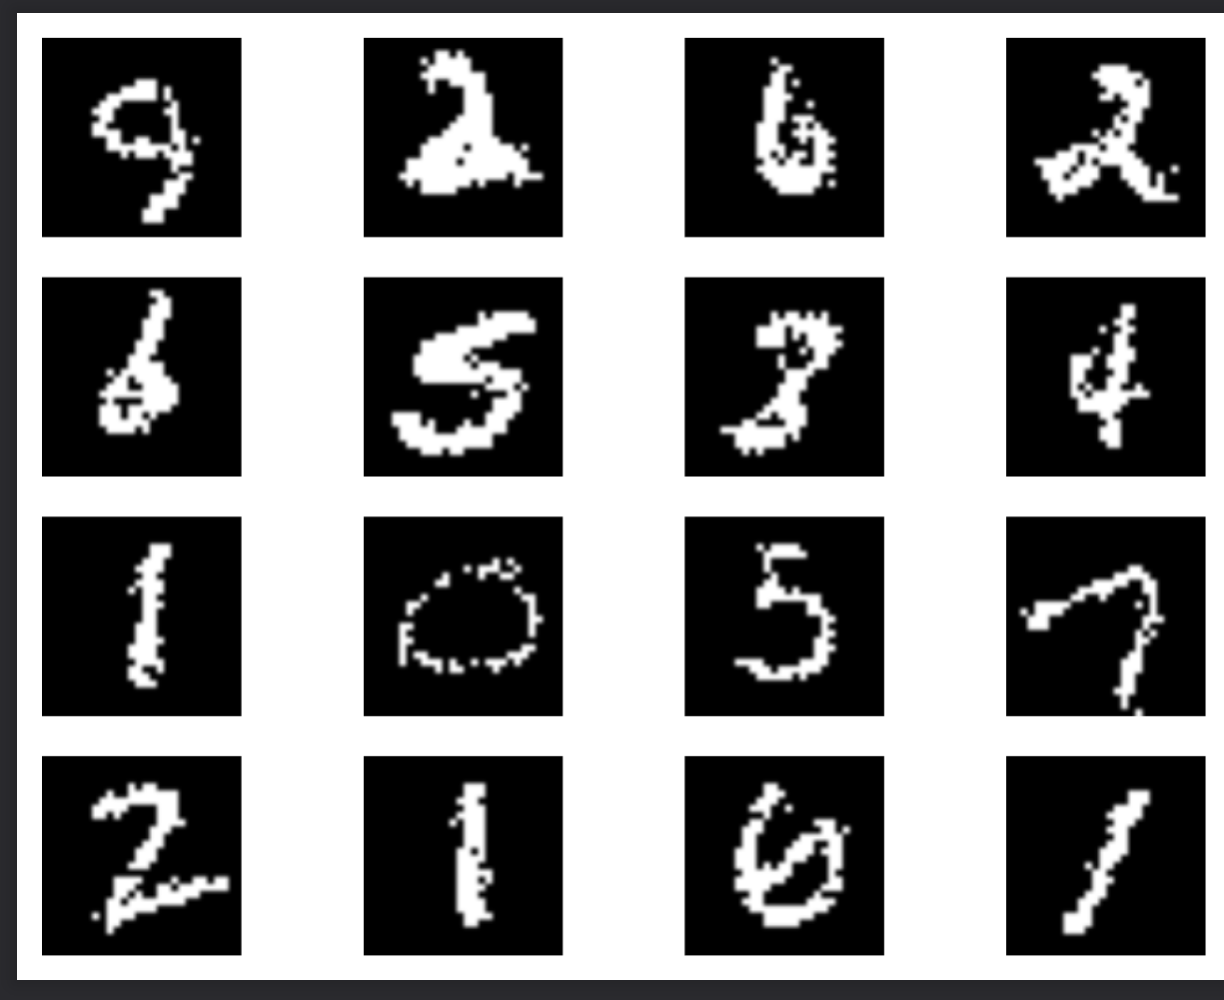
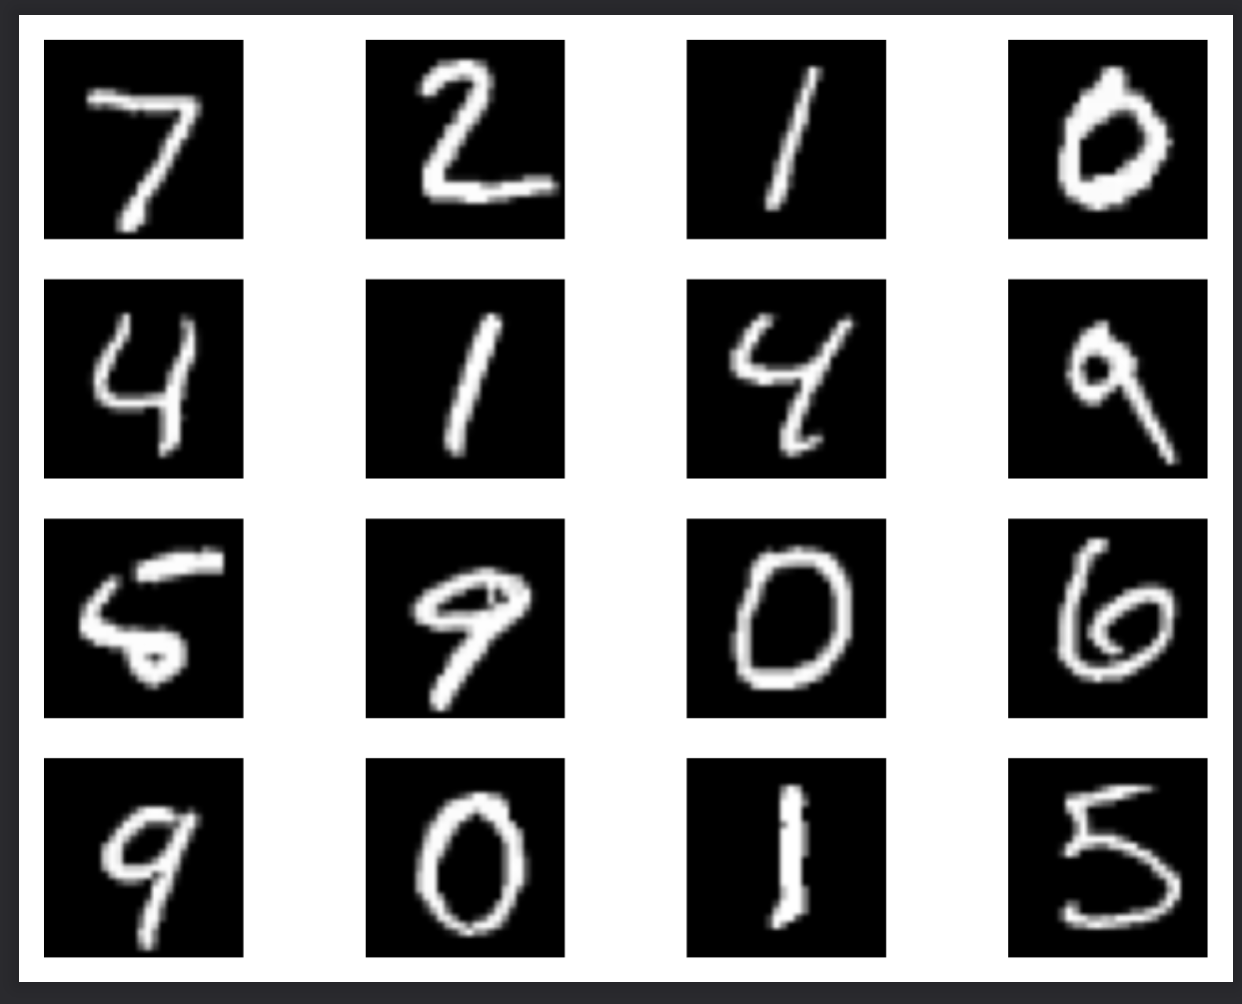

1) The generated digits are clearly identifiable.The shapes are coherent, correctly preserving the loops and strokes for each of the generated numbers ,  even though there is some bluriness (usual for VAEs).More importantly , the generated batch shows a wide variety of numbers rather than repeating patterns .This confirms that the model has learned the underlying data distribution and is not a victim of mode collapse. Also the final test loss of around 91.85 further solidifies the belief that the model was trained successfully .

2) a)  Potential problems could include **Subjectivity** -> quality could vary from person to person . It is not a quantifiable metric , **Overfitting** -> the model could reproduce training data pixel by pixel . A human could find this perfect but in reality the model has failed to learn the underlying distribution. **Mode Collapse** -> The model only generates specific digits and ignores the rest . This clearly indicates failure on learning the underlying distribution . However ,a quick visual check could miss that especially if the generated batch is small in size . 

b) **Fréchet Inception Distance (FID)** : This computes the distance between the distribution of real images and generated images in the feature space of a pre-trained Inception network. A lower FID indicates that the generated images are statistically similar to the real ones in terms of quality and diversity.

**Inception Score (IS)**: This measures two things: whether the generated images look like distinct objects (high confidence classification) and whether the model generates a diverse range of classes. A higher IS is better.






#### Question 9 (1.25 pt)

Please include the plot of the negative ELBO. Please comment on the following:
- (0.25 pt) Is the training of your VAE stable or unstable? Why?
- (1 pt) What is the influence of the optimizer on your model? Do the hyperparameter values of the optimizer important and how do they influence the training? Motivate well your answer (e.g., run the script with more than one learning rate and present two plots here).

ANSWER: 

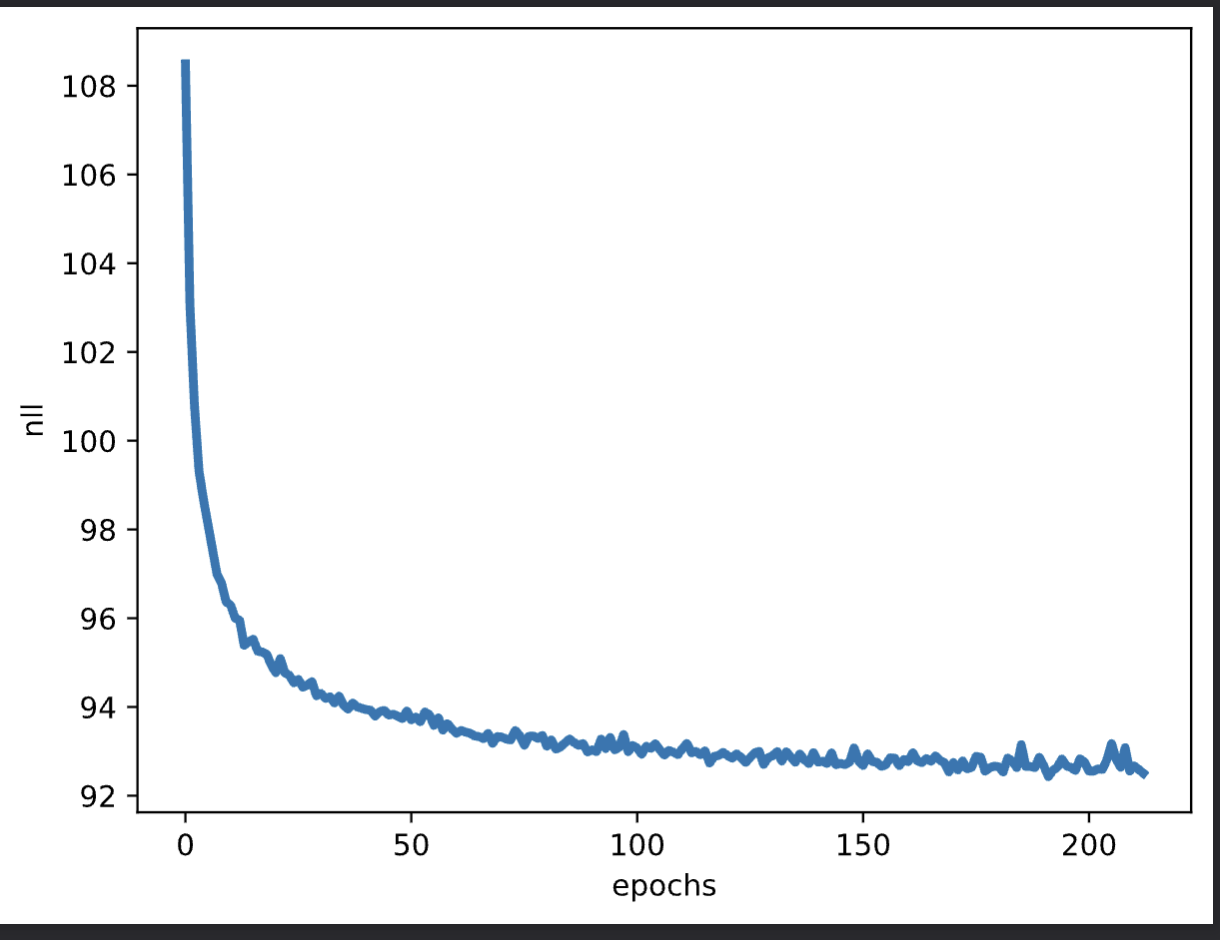

**1.**

As seen on in the plot of the NELBO using lr = 0.001 (1e-3), the loss shows a steady decrease over the epochs . This is especially true during the first 20 epochs , as the model probaly learns the primary features of the data followed by a flattening later on as the model converges .It is evident that the training is steady as there  is no wild oscillations or exploding loss values. However , there is some slight jittering but its completely normal for stochastic optimizations like Adam. 

**2.**

Both the optimizer and its hyperparameters are quite decisive in the training process, as they influence both the speed of convergence and the stability of the final model .

In this second NELBO plot we can see a model trained with a different lr = 0.0001 (1e-4) than the first one .

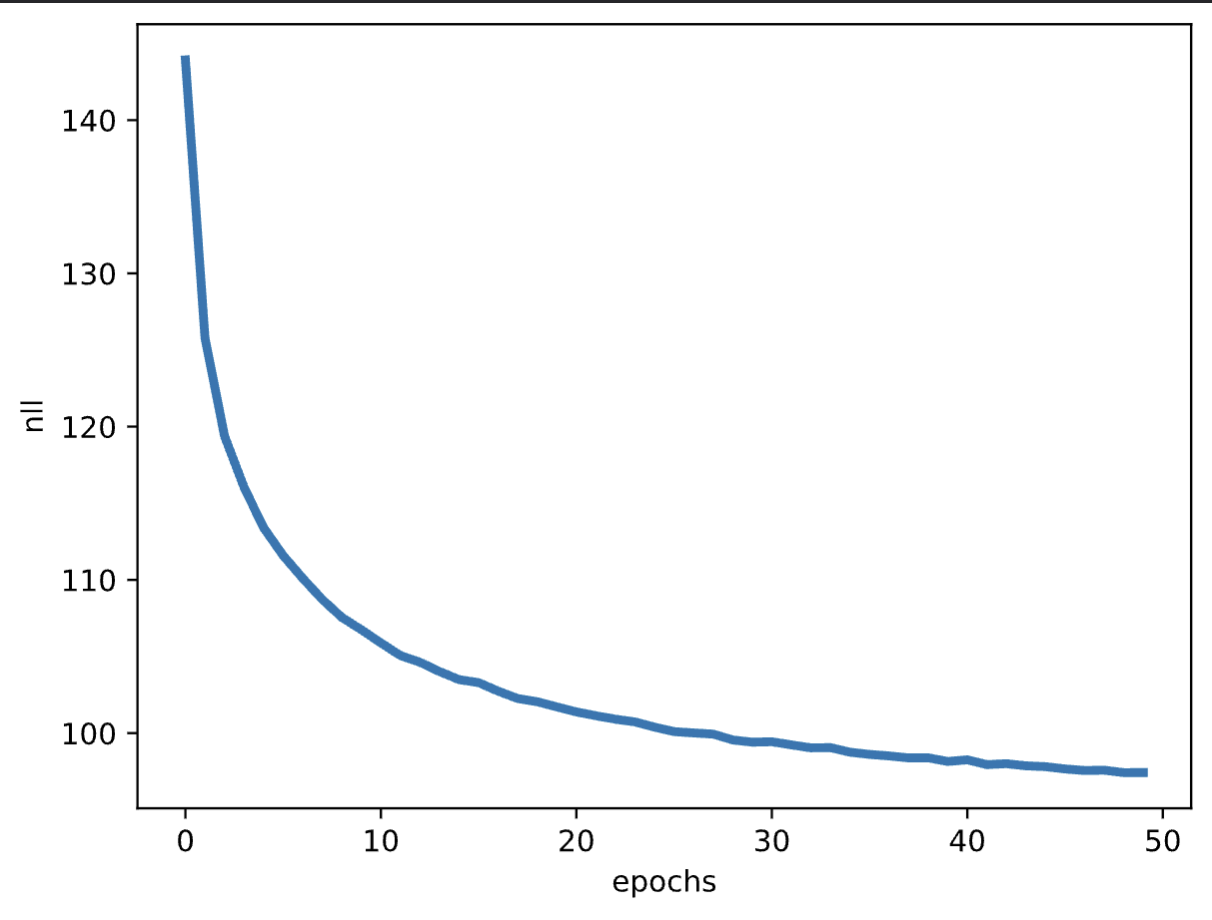

The comparison between the two plots clearly demonstrates the massive influence a learning rate can have on a model's training . 

-- The model with the lower learning rate ($1e-4$) converges significantly slower. Quantitatively, we can observe that by epoch 50, the model with the higher learning rate ($1e-3$) had already minimized the loss to approximately 94. In contrast, at the same 50-epoch mark, the model with the lower learning rate ($1e-4$) was still hovering around a loss of 98. This demonstrates that while the lower rate is stable, it requires substantially more training epochs to reach the same level of convergence.

--  the 1e-4  curve is obviously smoother but inefficient for this specific problem. This confirms our hypothesis from Question 7: a learning rate that is too small leads to safe but slow training, potentially failing to reach the optimal solution within a limited computational budget.

We can conclude that the optimizer determines heavily how the model learns . A properly tuned hyperparameter set  balances the trade off between stability and speed where untuned values can lead to inefficiency or even instability(if too low or too high ).

**Due to time restrictions we have trained the second model with the lower lr for only 50 epochs since it takes approx. 3 hours to stop .**

# Grading (10pt)

- Question 0: 3pt
- Question 1: 0.5pt 
- Question 2: 0.25pt 
- Question 3: 0.5pt 
- Question 4: 0.5pt 
- Question 5: 2pt 
- Question 6: 0.5pt
- Question 7: 0.5pt
- Question 8: 1pt
- Question 9: 1.25pt